<a href="https://colab.research.google.com/github/StrizhAXE/DataAlgoritm/blob/main/Les_4_Algs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [27]:
# сгенерируем данные
# для большей показательности возьмем n_samples=500
classification_data, classification_labels = datasets.make_classification(
                                                      n_samples=500, 
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant = 0, 
                                                      n_clusters_per_class = 1, 
                                                      random_state = 5
                                                                         )

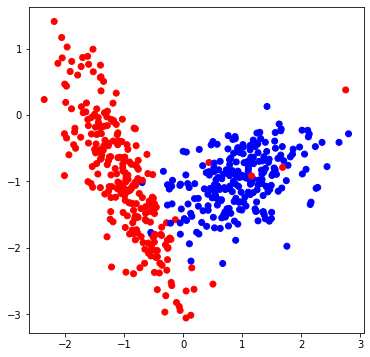

In [28]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [29]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [30]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

Индекс Джини:
$$H(X) = 1 - \sum^{K}_{k=1}p_{k}^{2}.$$

_энтропийный критерий_ или _энтропия Шеннона_

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}$$

In [31]:
# Расчет критерия качества Джини и энтропийного

def q_criterion(labels, type_q_criterion):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    if type_q_criterion == "gini":
        #  расчет критерия gini
        gini = 1 # коэффициент неопределенности Джини
        for label in classes:
            p = classes[label] / len(labels)
            gini -= p ** 2
        criterion = gini
    elif type_q_criterion == "entropy":
        #  расчет критерия entropy
        for label in classes:
            p = classes[label] / len(labels)
            entropy = -p * np.log2(p)
        criterion = entropy
    else:
        print(f"Не верный тип критерия качества")    
    return criterion

Функционал качества:  

$$Q = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r})$$

In [32]:
# Расчет качества

def quality(left_labels, right_labels, current_q_criterion, type_q_criterion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_q_criterion - p * q_criterion(left_labels, type_q_criterion) - (1 - p) * q_criterion(right_labels, type_q_criterion)

In [33]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [34]:
# 1. В коде из методички реализуйте один или несколько критериев останова (количество листьев, глубина дерева и т.д.).

In [35]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf, type_q_criterion): # добавим min_leaf и type_q_criterion во входные переменные
    
    current_q_criterion = q_criterion(labels, type_q_criterion)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_q_criterion, type_q_criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [36]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, min_leaf=5, max_deep_tree=10, type_q_criterion="entropy"):
    global deep_tree
    deep_tree += 1
    if deep_tree > max_deep_tree:
        return Leaf(data, labels)

    quality, t, index = find_best_split(data, labels, min_leaf, type_q_criterion)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        deep_tree = 0
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_leaf, max_deep_tree, type_q_criterion)
    false_branch = build_tree(false_data, false_labels, min_leaf, max_deep_tree, type_q_criterion)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    print(f"type_q_criterion = {type_q_criterion}")
    return Node(index, t, true_branch, false_branch)

In [37]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [38]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [39]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [40]:
# Построим дерево по обучающей выборке
deep_tree = 0
my_tree_gini = build_tree(train_data, train_labels, min_leaf=5, max_deep_tree=5, type_q_criterion='gini')

type_q_criterion = gini
type_q_criterion = gini
type_q_criterion = gini
type_q_criterion = gini
type_q_criterion = gini
type_q_criterion = gini
type_q_criterion = gini
type_q_criterion = gini


In [41]:
deep_tree = 0 # тупо конечно, не придумал умнее как занулить глубину дерева :)
my_tree_entropy = build_tree(train_data, train_labels, min_leaf=5, max_deep_tree=5, type_q_criterion="entropy")

type_q_criterion = entropy
type_q_criterion = entropy
type_q_criterion = entropy
type_q_criterion = entropy
type_q_criterion = entropy
type_q_criterion = entropy
type_q_criterion = entropy
type_q_criterion = entropy


In [42]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [43]:
# print_tree(my_tree_gini)

In [44]:
# print_tree(my_tree_entropy)

In [45]:
# Получим ответы для обучающей выборки 
train_answers_g = predict(train_data, my_tree_gini)
train_answers_e = predict(train_data, my_tree_entropy)

In [46]:
# И получим ответы для тестовой выборки
answers_g = predict(test_data, my_tree_gini)
answers_e = predict(test_data, my_tree_entropy)

$$accuracy=\frac{1}{l}\sum^l_{i=1}[pred_i=y_i]$$

In [47]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [48]:
# Точность на обучающей выборке
train_accuracy_g = accuracy_metric(train_labels, train_answers_g)
train_accuracy_e = accuracy_metric(train_labels, train_answers_e)
print(f"Accuracy train gini =    {np.round(train_accuracy_g, 5)} %")
print(f"Accuracy train entropy = {np.round(train_accuracy_e, 5)} %")

Accuracy train gini =    98.85714 %
Accuracy train entropy = 98.85714 %


In [49]:
# Точность на тестовой выборке
test_accuracy_g = accuracy_metric(test_labels, answers_g)
test_accuracy_e = accuracy_metric(test_labels, answers_e)
print(f"Accuracy test =    {np.round(test_accuracy_g, 5)} %")
print(f"Accuracy entropy = {np.round(test_accuracy_g, 5)} %")

Accuracy test =    94.66667 %
Accuracy entropy = 94.66667 %


In [50]:
# 2. Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. 
# Сравните качество классификации, сделайте выводы.


Вывод: На данном датасете нет различий качества классификации от выбранного критерия Джини или Энтропийного.